In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
from sklearn.datasets import load_breast_cancer, load_wine

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

## 1. Understanding Decision Trees

### Theory
- **Decision Tree**: Flowchart-like structure for classification
- **Nodes**: Test a feature
- **Branches**: Outcomes of the test
- **Leaves**: Final class predictions

**How it works**:
1. Start at root node
2. Split data based on feature that best separates classes
3. Repeat recursively
4. Stop when reaching pure nodes or max depth

In [2]:
# Load dataset
cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = cancer.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Classes: {cancer.target_names}")

Dataset: 569 samples, 30 features
Classes: ['malignant' 'benign']


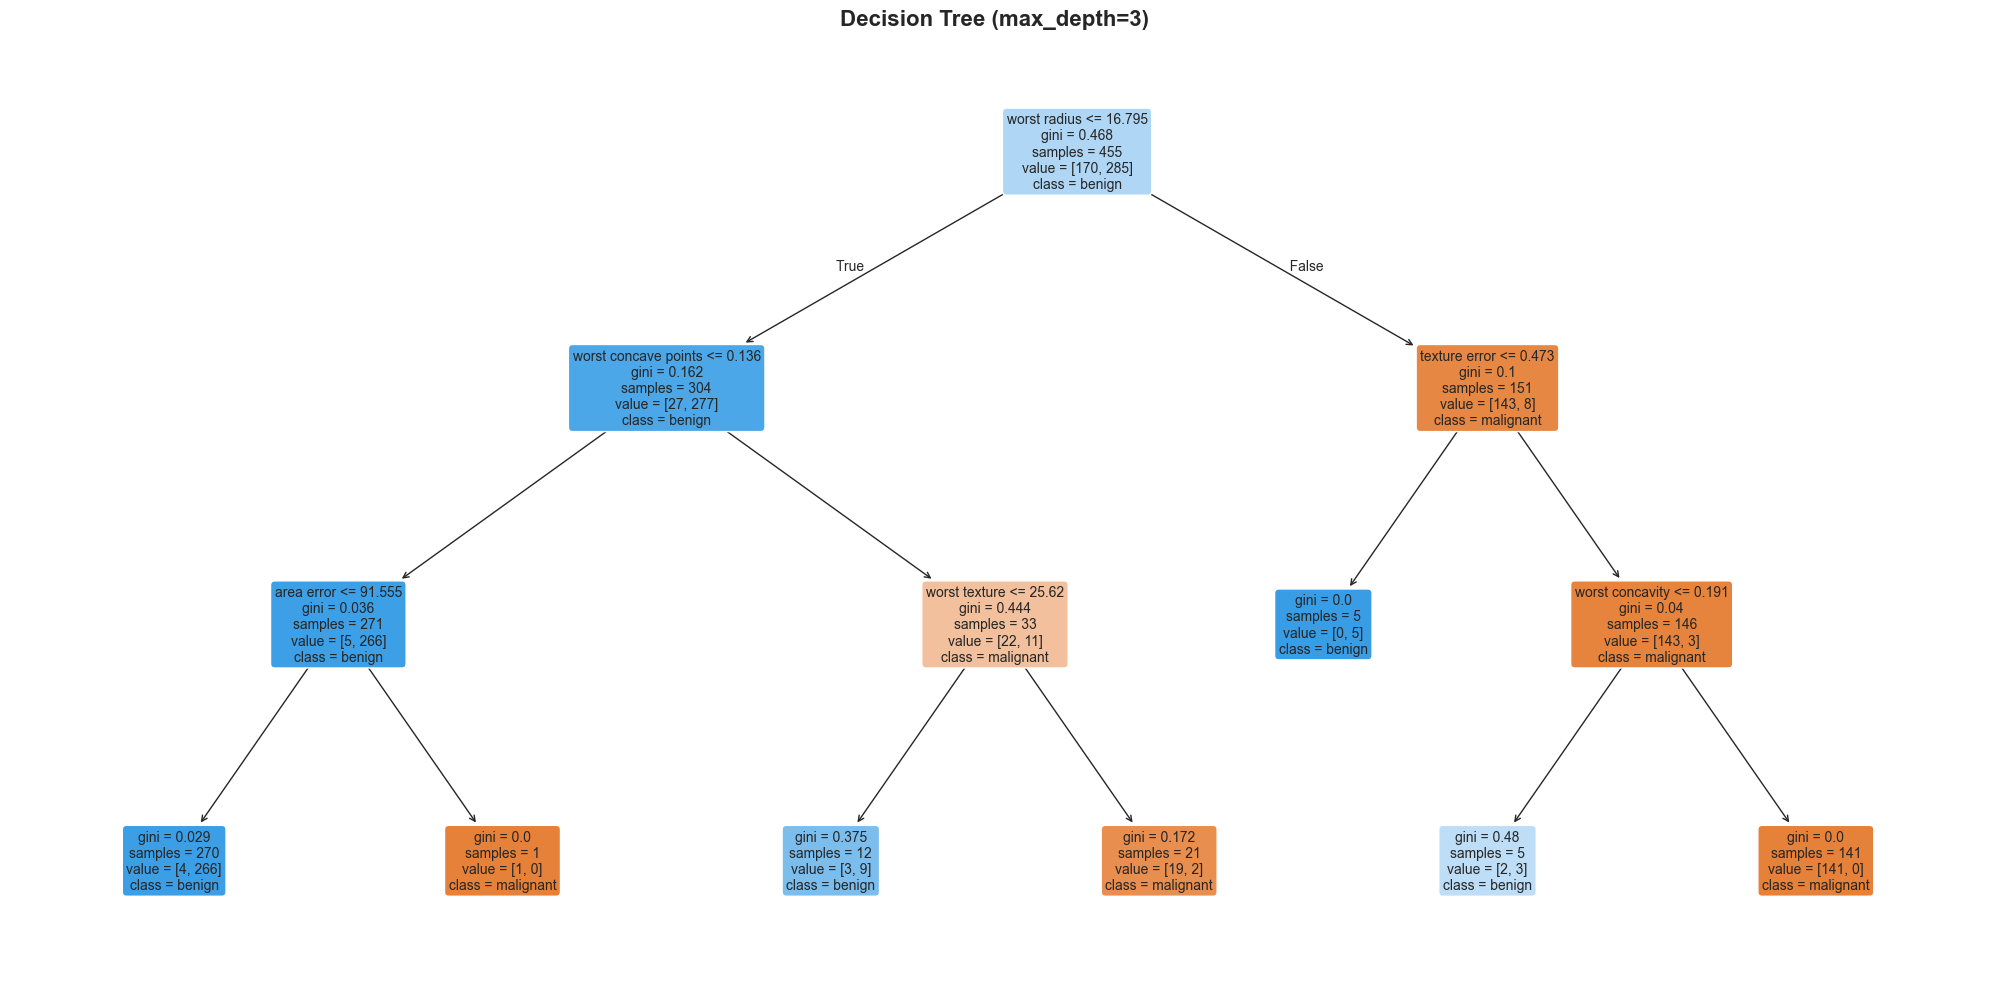


How to read this tree:
• Each box is a decision node
• Color indicates dominant class (darker = more confident)
• 'samples' shows number of training samples at that node
• 'value' shows [malignant_count, benign_count]


In [3]:
# Train a simple decision tree
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

# Visualize the tree
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=cancer.feature_names, 
          class_names=cancer.target_names, filled=True, 
          fontsize=10, rounded=True)
plt.title('Decision Tree (max_depth=3)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nHow to read this tree:")
print("• Each box is a decision node")
print("• Color indicates dominant class (darker = more confident)")
print("• 'samples' shows number of training samples at that node")
print("• 'value' shows [malignant_count, benign_count]")

## 2. Problem with Single Decision Trees

Decision trees tend to **overfit** - they memorize training data!

Depth=2          | Train: 0.9582 | Test: 0.8947
Depth=5          | Train: 0.9934 | Test: 0.9211
Depth=10         | Train: 1.0000 | Test: 0.9123
Depth=20         | Train: 1.0000 | Test: 0.9123
Depth=Unlimited  | Train: 1.0000 | Test: 0.9123


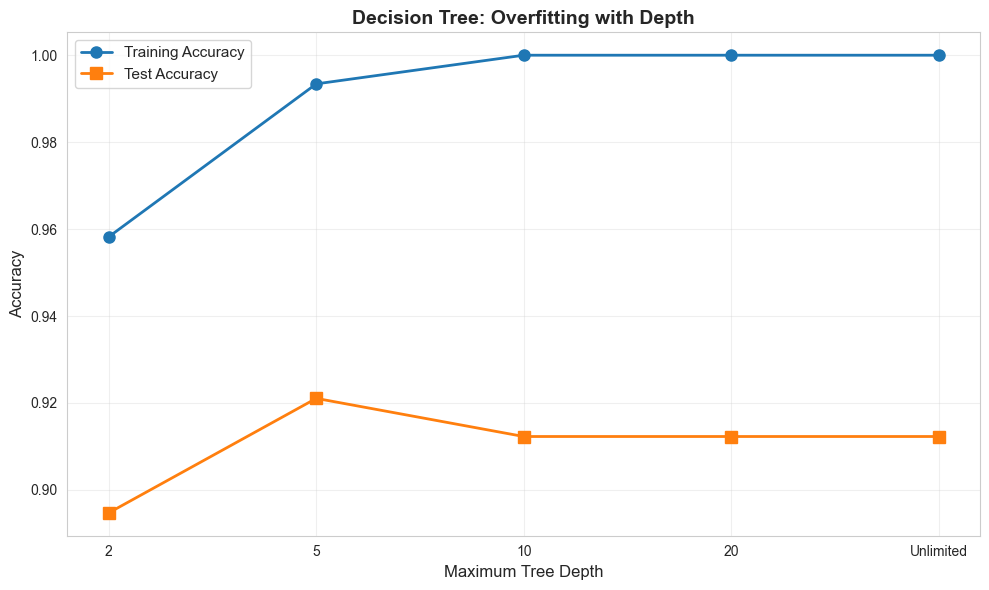


⚠️  Notice: Deep trees overfit (high train, lower test accuracy)


In [4]:
# Compare shallow vs deep trees
depths = [2, 5, 10, 20, None]  # None = unlimited depth
train_scores = []
test_scores = []

for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    train_scores.append(tree.score(X_train, y_train))
    test_scores.append(tree.score(X_test, y_test))
    
    depth_str = str(depth) if depth else 'Unlimited'
    print(f"Depth={depth_str:10s} | Train: {train_scores[-1]:.4f} | Test: {test_scores[-1]:.4f}")

# Plot
x_labels = [str(d) if d else 'Unlimited' for d in depths]
x_pos = np.arange(len(depths))

plt.figure(figsize=(10, 6))
plt.plot(x_pos, train_scores, marker='o', linewidth=2, 
         markersize=8, label='Training Accuracy')
plt.plot(x_pos, test_scores, marker='s', linewidth=2, 
         markersize=8, label='Test Accuracy')
plt.xticks(x_pos, x_labels)
plt.xlabel('Maximum Tree Depth', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Decision Tree: Overfitting with Depth', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n⚠️  Notice: Deep trees overfit (high train, lower test accuracy)")

## 3. Random Forest to the Rescue! 🌲🌳🌲

### Ensemble Learning
**Random Forest** = Many decision trees voting together

**Key Ideas**:
1. **Bootstrap Aggregating (Bagging)**: Train each tree on random subset of data
2. **Feature Randomness**: Each split considers random subset of features
3. **Voting**: Final prediction is majority vote (classification)

**Benefits**:
- Reduces overfitting
- More robust predictions
- Handles missing data well
- Provides feature importance

In [5]:
# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=100,      # Number of trees
    max_depth=10,          # Max depth of each tree
    random_state=42,
    n_jobs=-1              # Use all CPU cores
)

rf.fit(X_train, y_train)

print("✅ Random Forest trained successfully!")
print(f"\nNumber of trees: {rf.n_estimators}")
print(f"Number of features: {rf.n_features_in_}")
print(f"Number of classes: {rf.n_classes_}")

✅ Random Forest trained successfully!

Number of trees: 100
Number of features: 30
Number of classes: 2


## 4. Model Evaluation

In [6]:
# Make predictions
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
y_test_proba = rf.predict_proba(X_test)

# Evaluate
def print_metrics(y_true, y_pred, y_proba, set_name):
    print(f"\n{'='*60}")
    print(f"{set_name} Metrics")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score:  {f1_score(y_true, y_pred):.4f}")
    print(f"ROC-AUC:   {roc_auc_score(y_true, y_proba[:, 1]):.4f}")

print_metrics(y_train, y_train_pred, rf.predict_proba(X_train), "Training Set")
print_metrics(y_test, y_test_pred, y_test_proba, "Test Set")


Training Set Metrics
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC-AUC:   1.0000

Test Set Metrics
Accuracy:  0.9561
Precision: 0.9589
Recall:    0.9722
F1-Score:  0.9655
ROC-AUC:   0.9937


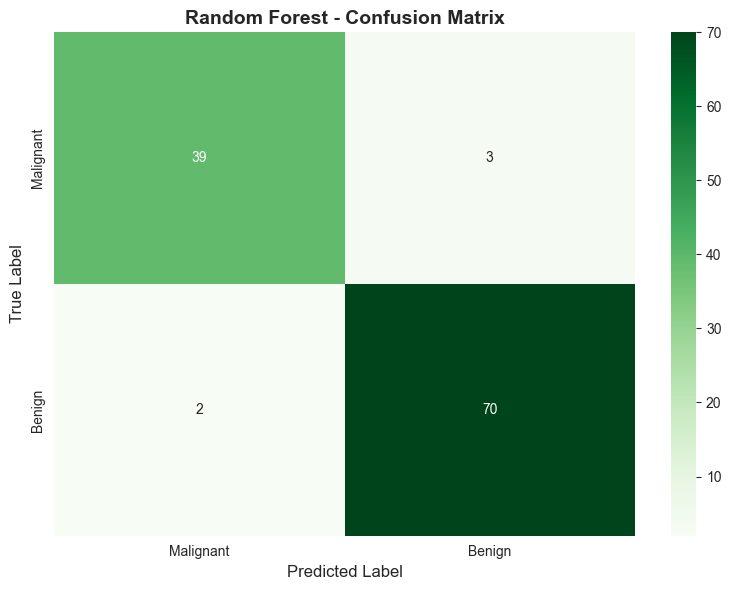


Classification Report:
              precision    recall  f1-score   support

   malignant       0.95      0.93      0.94        42
      benign       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [7]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, 
                          target_names=cancer.target_names))

## 5. Feature Importance Analysis

One of the best things about Random Forests!

Top 10 Most Important Features:
             Feature  Importance
          worst area    0.140016
worst concave points    0.129530
        worst radius    0.097696
 mean concave points    0.090885
     worst perimeter    0.072226
      mean perimeter    0.069574
         mean radius    0.068676
      mean concavity    0.057638
           mean area    0.049172
     worst concavity    0.034340


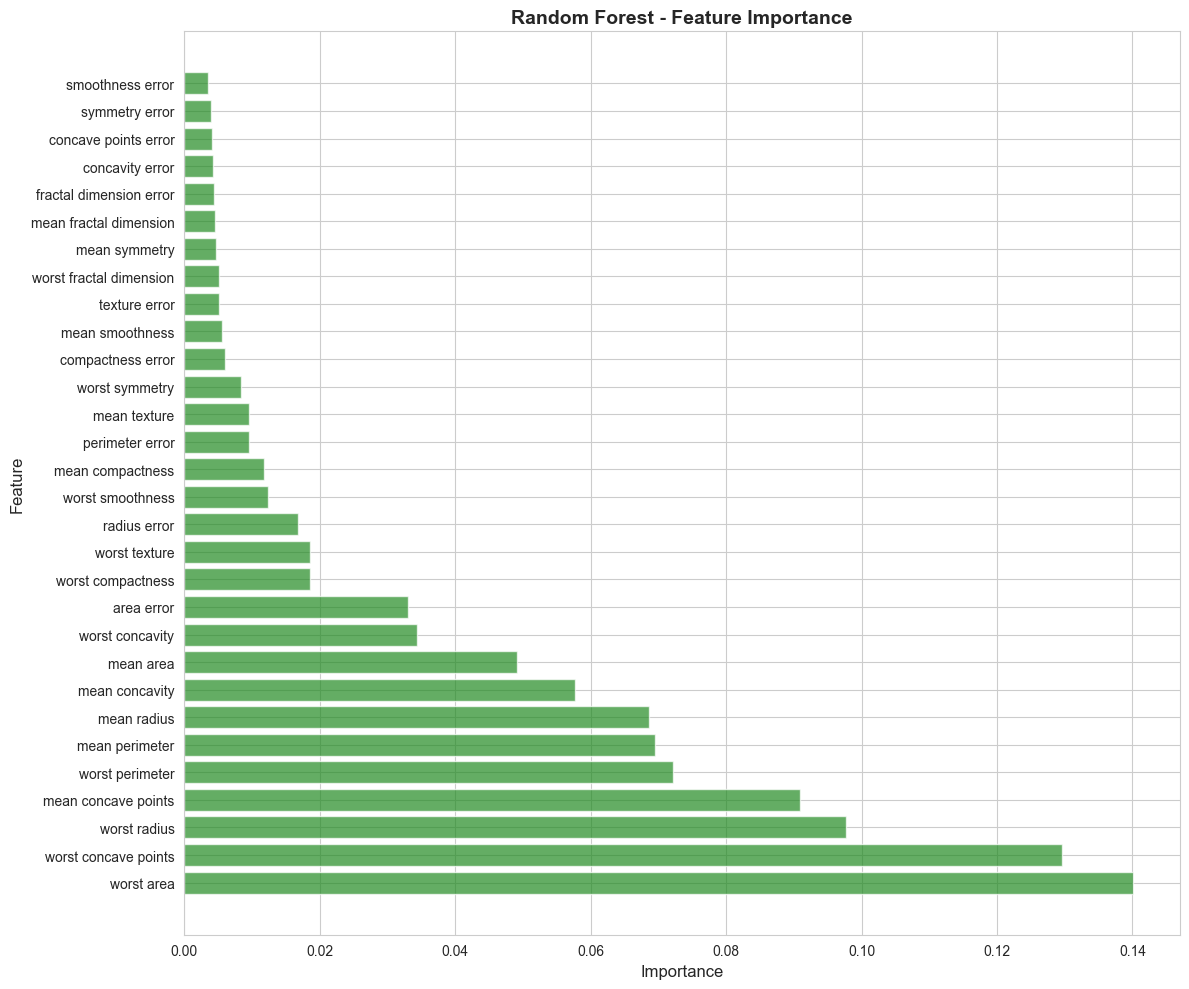


📊 Interpretation:
• Higher values = more important for predictions
• Sum of all importances = 1.0
• Based on how much each feature reduces impurity across all trees


In [8]:
# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': cancer.feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Visualize all features
plt.figure(figsize=(12, 10))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], 
         color='forestgreen', alpha=0.7)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest - Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("• Higher values = more important for predictions")
print("• Sum of all importances = 1.0")
print("• Based on how much each feature reduces impurity across all trees")

## 6. Compare Single Tree vs Random Forest


Model Comparison:
                    Model  Train Accuracy  Test Accuracy  Precision   Recall  F1-Score  ROC-AUC
     Single Decision Tree             1.0       0.912281   0.955882 0.902778  0.928571 0.915675
Random Forest (100 trees)             1.0       0.956140   0.958904 0.972222  0.965517 0.993717


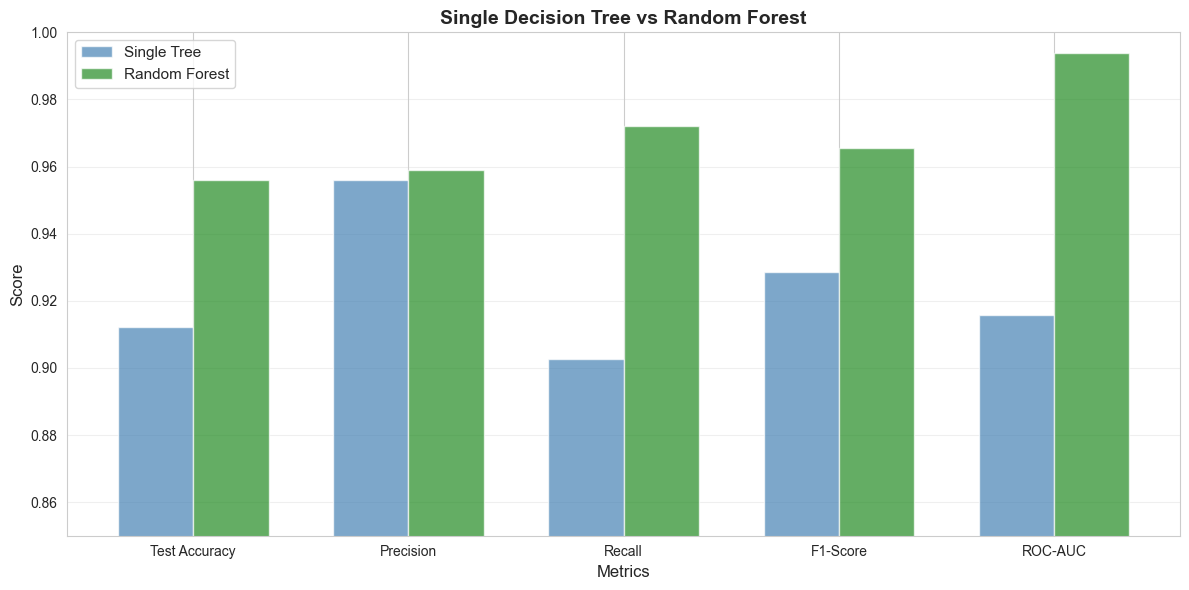


🌟 Random Forest typically performs better and is more robust!


In [9]:
# Train single decision tree
single_tree = DecisionTreeClassifier(max_depth=10, random_state=42)
single_tree.fit(X_train, y_train)

# Compare performance
models = {
    'Single Decision Tree': single_tree,
    'Random Forest (100 trees)': rf
}

results = []
for name, model in models.items():
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    test_pred = model.predict(X_test)
    test_proba = model.predict_proba(X_test)
    
    results.append({
        'Model': name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Precision': precision_score(y_test, test_pred),
        'Recall': recall_score(y_test, test_pred),
        'F1-Score': f1_score(y_test, test_pred),
        'ROC-AUC': roc_auc_score(y_test, test_proba[:, 1])
    })

comparison_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(comparison_df.to_string(index=False))

# Visualize
metrics = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, [comparison_df.iloc[0][m] for m in metrics], 
       width, label='Single Tree', color='steelblue', alpha=0.7)
ax.bar(x + width/2, [comparison_df.iloc[1][m] for m in metrics], 
       width, label='Random Forest', color='forestgreen', alpha=0.7)

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Single Decision Tree vs Random Forest', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.set_ylim(0.85, 1.0)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n🌟 Random Forest typically performs better and is more robust!")

## 7. Effect of Number of Trees

Testing different numbers of trees...
Trees=  1 | Train: 0.9714 | Test: 0.9474
Trees=  5 | Train: 0.9912 | Test: 0.9386
Trees= 10 | Train: 0.9956 | Test: 0.9386
Trees= 25 | Train: 1.0000 | Test: 0.9561
Trees= 50 | Train: 1.0000 | Test: 0.9561
Trees=100 | Train: 1.0000 | Test: 0.9561
Trees=200 | Train: 1.0000 | Test: 0.9561
Trees=500 | Train: 1.0000 | Test: 0.9561


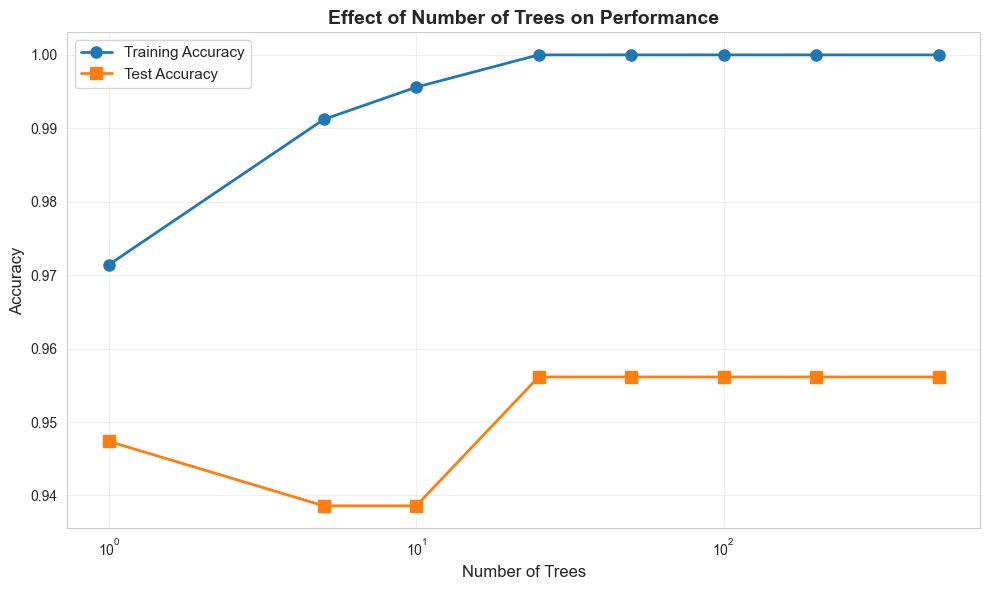


💡 Insights:
• More trees generally improve performance
• But returns diminish after ~100-200 trees
• More trees = longer training time
• Sweet spot: 100-200 trees for most problems


In [10]:
# Test different numbers of trees
n_trees_list = [1, 5, 10, 25, 50, 100, 200, 500]
train_scores = []
test_scores = []

print("Testing different numbers of trees...")
for n_trees in n_trees_list:
    rf_temp = RandomForestClassifier(n_estimators=n_trees, random_state=42, n_jobs=-1)
    rf_temp.fit(X_train, y_train)
    
    train_scores.append(rf_temp.score(X_train, y_train))
    test_scores.append(rf_temp.score(X_test, y_test))
    
    print(f"Trees={n_trees:3d} | Train: {train_scores[-1]:.4f} | Test: {test_scores[-1]:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(n_trees_list, train_scores, marker='o', linewidth=2, 
         markersize=8, label='Training Accuracy')
plt.plot(n_trees_list, test_scores, marker='s', linewidth=2, 
         markersize=8, label='Test Accuracy')
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Effect of Number of Trees on Performance', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.tight_layout()
plt.show()

print("\n💡 Insights:")
print("• More trees generally improve performance")
print("• But returns diminish after ~100-200 trees")
print("• More trees = longer training time")
print("• Sweet spot: 100-200 trees for most problems")

## 8. Hyperparameter Tuning

In [11]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Starting Grid Search...")
print(f"Total combinations to test: {np.prod([len(v) for v in param_grid.values()])}")
print("This may take a minute...\n")

# Grid search with cross-validation
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n✅ Grid Search Complete!")
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
print(f"Test set score: {grid_search.score(X_test, y_test):.4f}")

Starting Grid Search...
Total combinations to test: 108
This may take a minute...

Fitting 5 folds for each of 108 candidates, totalling 540 fits

✅ Grid Search Complete!

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.9604
Test set score: 0.9561


In [12]:
# Compare default vs tuned model
best_rf = grid_search.best_estimator_
y_test_pred_tuned = best_rf.predict(X_test)

print("\nDefault Model vs Tuned Model:")
print("="*60)
print(f"Default Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Tuned Test Accuracy:   {accuracy_score(y_test, y_test_pred_tuned):.4f}")
print(f"\nImprovement: {(accuracy_score(y_test, y_test_pred_tuned) - accuracy_score(y_test, y_test_pred))*100:+.2f}%")


Default Model vs Tuned Model:
Default Test Accuracy: 0.9561
Tuned Test Accuracy:   0.9561

Improvement: +0.00%


## 9. Cross-Validation

10-Fold Cross-Validation Results:
Scores: [0.97826087 0.95652174 0.97826087 0.97826087 0.89130435 0.97777778
 0.97777778 0.91111111 1.         0.93333333]

Mean: 0.9583
Std:  0.0332
95% CI: [0.8932, 1.0234]


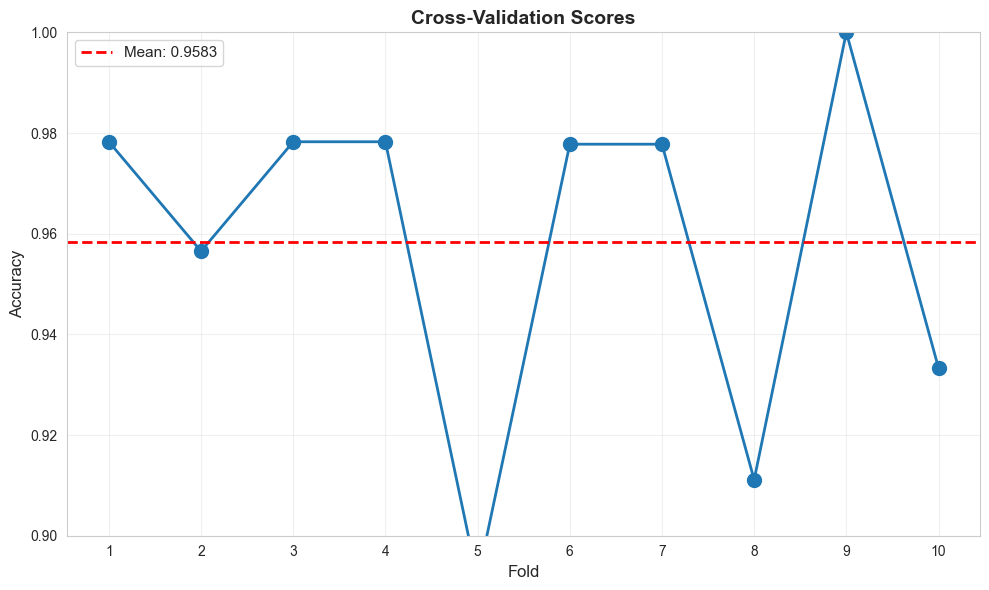

In [13]:
# Perform 10-fold cross-validation
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=10, scoring='accuracy')

print("10-Fold Cross-Validation Results:")
print("="*50)
print(f"Scores: {cv_scores}")
print(f"\nMean: {cv_scores.mean():.4f}")
print(f"Std:  {cv_scores.std():.4f}")
print(f"95% CI: [{cv_scores.mean() - 1.96*cv_scores.std():.4f}, "
      f"{cv_scores.mean() + 1.96*cv_scores.std():.4f}]")

# Visualize
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), cv_scores, marker='o', linewidth=2, markersize=10)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', 
            linewidth=2, label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Cross-Validation Scores', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 11))
plt.ylim(0.9, 1.0)
plt.tight_layout()
plt.show()

## 🎯 Key Takeaways

1. **Random Forest Advantages**:
   - Reduces overfitting compared to single trees
   - Handles non-linear relationships
   - Robust to outliers
   - No feature scaling needed
   - Provides feature importance

2. **Important Hyperparameters**:
   - `n_estimators`: Number of trees (more is better, but diminishing returns)
   - `max_depth`: Max tree depth (controls overfitting)
   - `min_samples_split`: Min samples to split a node
   - `min_samples_leaf`: Min samples in leaf node
   - `max_features`: Features to consider for each split

3. **When to Use Random Forest**:
   - ✅ Complex non-linear problems
   - ✅ Need feature importance
   - ✅ Have enough training data
   - ❌ Need model interpretability (use logistic regression)
   - ❌ Real-time predictions (can be slow)

4. **Feature Importance**: Great for understanding which features matter most!